# Prediction in an Era of Unpredictability

In [1]:
import codecs
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import string

from pprint import pprint
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from gensim import corpora, models

## Research questions

To better dissect the data and extract insights, we will explore the following questions:

1. Which socio-economic factors have the biggest impact, if any, in building or altering popular opinion?
    * Standard and Quality of Education (Wikidata, Educational databases)
    * Income and Inequality Levels (Wikidata)
</br>

2. How does media through newspapers and social networks influence these events through information or misinformation?
    * Newspaper (Corpus Data)
    * Social Media (Twitter)
</br>

3. What is the influence of the political system in place?
    * Political System
    * Rate of Abstention (Wikidata)
    * Demonstrations Covered in Media (Corpus Data)
</br>

4. How far in time could we have traced the roots of such events? (Wikidata, Newspapers)

### 1. Which socio-economic factors have the biggest impact, if any, in building or altering popular opinion?

#### Standard and Quality of Education (Wikidata)

In [2]:
edu_df = pd.DataFrame(columns=['Country',
                               'Total Literacy',
                               'Secondary Diploma',
                               'Post-Secondary Diploma',
                               'Total Enrolled',
                               'National Education Budget'])

In [3]:
edu_df.loc[len(edu_df)] = ['United States',
                           '100%',
                           '81%',
                           '30%',
                           '81.5 million',
                           '1 trillion']

edu_df.loc[len(edu_df)] = ['United Kingdom',
                           '99%',
                           '87%',
                           '41%',
                           '11.7 million',
                           '62.2 billion']

edu_df.loc[len(edu_df)] = ['Spain',
                           '98.1%',
                           '45.4%',
                           '38.1%',
                           '5.9 million',
                           '4.04 billion']

In [4]:
edu_df.head()

,Country,Total Literacy,Secondary Diploma,Post-Secondary Diploma,Total Enrolled,National Education Budget
0,United States,100%,81%,30%,81.5 million,1 trillion
1,United Kingdom,99%,87%,41%,11.7 million,62.2 billion
2,Spain,98.1%,45.4%,38.1%,5.9 million,4.04 billion


Sources: 
- https://en.wikipedia.org/wiki/Education_in_the_United_States
- https://en.wikipedia.org/wiki/Education_in_England
- https://en.wikipedia.org/wiki/List_of_Ministers_of_Education_of_Spain

### 2. How does media through newspapers and social networks influence these events through information or misinformation?

### Data Sets
For this question, we will focus on newspaper articles from the United States, United Kingdom, and Spain from the News On The Web Corpus Dataset. In terms of data collection, we will rely on articles regarding the U.S 2016 Presidential Election. We present here a short analysis for the the case of the United States Trump Election:

### Strategies 

The first approach could make use of the Term Frequency (TF) and Inverse Document Frequency (IDF) methods. This approach would find the most frequent words between some texts of the corpus.
- TF for a term “t” is defined as the count of a term “t” in a document “D”
- IDF for a term is defined as logarithm of ratio of total documents available in the corpus and number of documents containing the term "T"
However this first approach requires the use of classes in the corpus. The classes that we could define could be 
1. The newspapers
2. Article containing Trump article not containing trump
3. Classes created depending of topic (This would require a preprocessing with topic modelling analysis such as Latent Dirichlet Allocation).
Then we could use an unsupervised approach to find similarities between the newspapers based on the word associations

The second approach would be a skip- gram model or a Fasttext (FastText version for word vector representations and analogies). 
- This approach would find the top words associated with the keywords Trump in each of the articles. 
- Then a corpus of this words could be created and IDs could be associated to them to create a Trump-word matric in each newspaper. From this an unsupervised clustering method could find similarities between newspapers based on the words used to talk about the event 

### Data Pre-Processing 
To select the appropriate articles, we iterate through all of the articles from 2016 within the corpus and only select those with key terms relevant to this topic (i.e. 'election', 'Trump', etc). Once we have these relevant articles, we convert the text to lowercase, remove the punctuation so words are not tokenized with the punctuation marks, remove common stopwords from the text, and then find the most important or trending words using the method described below.
 

#### Source Files

In [5]:
SOURCE_1_PATH = "./Data/now_sources_pt1.txt"
SOURCE_2_PATH = "./Data/now_sources_pt2.txt"
DATA_PATH = "./Data/16-10-us.full.txt"
ENCODING = "latin1"

COLUMN_NAMES = ['TextID',
                'Number of Words',
                'Date',
                'Country',
                'Source',
                'Link',
                'Headline']

In [6]:
# open the source index files
with codecs.open(SOURCE_1_PATH, "r", encoding=ENCODING) as f:
    pt1 = pd.read_csv(f, sep="\t", names = COLUMN_NAMES)
    
pt1.head()

,TextID,Number of Words,Date,Country,Source,Link,Headline
0,1334669,334,10-01-01,US,The Next Web,http://thenextweb.com/2010/01/01/avatar-takes-...,Believe it or not: Avatar takes 1 petabyte of ...
1,1334671,493,10-01-01,US,People Magazine,"http://www.people.com/people/article/0,,203339...",INSIDE STORY: The Making of Beyonc's 'Single ...
2,1334672,1255,10-01-01,US,San Francisco Chronicle,http://www.sfgate.com/bayarea/article/Biblical...,"Biblical scholar's date for rapture: May 21, 2011"
3,1334673,695,10-01-01,US,CNN,http://www.cnn.com/2010/HEALTH/01/01/multi.vit...,What you need to know about multivitamins
4,1334674,724,10-01-01,US,MedPage Today,http://www.medpagetoday.com/Psychiatry/sleepdi...,Lack of Sleep Linked to Depression in Adolescents


In [7]:
with codecs.open(SOURCE_2_PATH, "r", encoding="latin1") as f:
    pt2 = pd.read_csv(f, sep="\t", names = COLUMN_NAMES)
    
pt2.head()

,TextID,Number of Words,Date,Country,Source,Link,Headline
0,2930853,194,15-01-01,US,Consequence of Sound,http://consequenceofsound.net/2015/01/100000-c...,100000 copies of The Interview will be dropped...
1,2930854,266,15-01-01,US,Los Angeles Times,http://www.latimes.com/entertainment/movies/la...,'The Taking of Tiger Mountain' gets blockbuste...
2,2930855,701,15-01-01,US,TIME,http://time.com/3651697/afghanistan-war-cost/,The True Cost of the Afghanistan War May Surpr...
3,2930856,1963,15-01-01,US,The Week Magazine,http://theweek.com/articles/441310/confessions...,Confessions of a former TSA officer
4,2930859,263,15-01-01,US,Russia Beyond the Headlines,http://rbth.com/arts/2015/01/01/year_of_litera...,"Pushkin, Gogol and Akhmatova to be symbols of ..."


#### Newspaper Contents

In [8]:
# read all the lines in the file
with codecs.open(DATA_PATH, "r", encoding=ENCODING) as f:
    lines = f.readlines()

# list to store all the lines read from the data file
data = []

# append all the lines to the list called data
for line in lines:
    data.append(line)

# create DataFrame using the list of lines
df = pd.DataFrame(data, columns=["Content"])
df.head(10)

,Content
0,@@14637197 <p> NEW YORK ( AP ) -- Donald Trump...
1,@@14637200 <h> Here 's all the crazy stuff tha...
2,@@14637201 <h> Another hotel wants to build in...
3,"@@14637202 <p> In this Sept. 23 , 2016 photo ,..."
4,@@14637203 <h> Court erases jury award of puni...
5,@@14637204 <p> A flurry of small earthquakes n...
6,@@14637207 <h> After a dominant win over Stanf...
7,@@14637209 <h> Story Highlights <p> A dramatic...
8,@@14637213 <h> Hueneme suffers first loss of s...
9,@@14637215 <p> CLOVERDALE -- A Napoleon woman ...


We replace all the punctuations in the text with a space. We first tried to replace it with an empty sequence but that replaces words such as "Trump's" with "Trumps". More importantly, finding all the relevant keywords using a regex also selects articles with words "trumpets", "selection", etc. which have the words "trump", "election" as substrings. So, we try to find the words "trump ", "election ", both ending with a space. So we need to replace punctuations with a space to find those words.

#### Pre Processing 

In [9]:
# function to replace all the punctuations with a space
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, " ")
    return text

# convert all text to lowercase
df["Content"] = df["Content"].str.lower()

# apply function to the given column
df["Content"] = df["Content"].apply(remove_punctuations)

print(df.head(10))
print("\nNumber of articles = {}".format(df.shape[0]))

                                             Content
0    14637197  p  new york   ap      donald trump...
1    14637200  h  here  s all the crazy stuff tha...
2    14637201  h  another hotel wants to build in...
3    14637202  p  in this sept  23   2016 photo  ...
4    14637203  h  court erases jury award of puni...
5    14637204  p  a flurry of small earthquakes n...
6    14637207  h  after a dominant win over stanf...
7    14637209  h  story highlights  p  a dramatic...
8    14637213  h  hueneme suffers first loss of s...
9    14637215  p  cloverdale    a napoleon woman ...

Number of articles = 26028


In [10]:
# list of forbidden words that are very common in throughout all articles in journalism and should have less importance
Forbiddenwords=['said',
                'say',
                'tell',
                'just',
                'will',
                'one',
                'said',
                'say',
                'tell',
                'will',
                'have',
                'not',
                'would',
                'new',
                'like',
                'year']

#### Word Lemma Pos

An additional step to preprocessing will include replacing each word with it's lemma. We will also account for the stem of the word. For instance, 'immigrant' and 'immigration' have the same root. We will complete this portion by using data from the wlp (word lemma pos) section from the corpus database.

In [11]:
# Here we take care of stop words, numbers, map with
# the word lemma pos dictionary (equivalent to Steming) 
# and we create an additional column with Ids
id_=np.zeros(df.shape[0])
stop_flag=True

for idx, text in enumerate(df['Content']):
# convert tweet to tokens
    tknzr = TweetTokenizer()
    text = tknzr.tokenize(text)

# replace stopwords
    if stop_flag:
        stop = stopwords.words("english") 
        text = [token for token in text if token not in stop]
               
    # apply stemming 
    # create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    text = [p_stemmer.stem(i) for i in text[1:]] # keep index
    
# remove forbidden library
    text = [i for i in text if len((set([i]) & set(Forbiddenwords)))==0] # keep index
    

# store ID in a separate column  
    if text[0].isdigit():
        id_[idx]=int(text[0])
    
# remove numbers
    text = [i for i in text if not i.isdigit()]  
    
# reconcatenate Tokens
    text = " ".join(text)
   
    df.loc[idx] = text

In [12]:
# create the id column
df['TextID']=id_

df.head()

#### Selection of the articles of interest

In [14]:
# to store all the articles relevant to our project from the file
relevant_keywords = ["election",
                     "trump",
                     "donald"
                     "clinton",
                     "hillary"]

# NOTE: add a space between the OR | symbol between the words so
# we do not choose words which have relevant words as substrings
relevant_regex = " |".join(relevant_keywords)

# find all articles which contain any of the relevant keywords
df = df[df["Content"].str.contains(relevant_regex)]

print(df.head(10))
print("\nNumber of articles = {}".format(df.shape[0]))

                                               Content      TextID
0    p york ap donald trump five day feud former be...  14637197.0
10   h utility rates old market fire minds candidat...  14637217.0
44   p file june file photo homeland security depar...  14638417.0
45   p iowa city powerful university iowa administr...  14638418.0
54   h tired rancor presidential politics check spi...  14638430.0
77   h start listening audiobooks days free audible...  14639013.0
81   h death shimon peres israel lost moral compass...  14639017.0
87   p wbns tv line public inspection file found fc...  14639582.0
92   h multiple fresh signs economic reports showin...  14639591.0
102  p donald trump walks stage speaking rally frid...  14639602.0

Number of articles = 4814


#### Create categories of articles for the TF-IDF analysis

Here we test a simple Latent Dirichlet Allocation analysis to create article classes (Such as election, immigration..). This is a very basi model that could be improved 

In [15]:
concat_texts=[]
for i in df['Content']:
    # tknzr = TweetTokenizer(strip_handles=handles, reduce_len=length)s
    tknzr = RegexpTokenizer(r'[A-Za-z]\w+')
    text = tknzr.tokenize(i)
    concat_texts.append(text)

In [16]:
# create dictionary 
dictionary = corpora.Dictionary(concat_texts)

In [17]:
# create vectors for each text 
corpus = [dictionary.doc2bow(t) for t in concat_texts]
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 3), (46, 3), (47, 1), (48, 2), (49, 2), (50, 2), (51, 3), (52, 1), (53, 1), (54, 2), (55, 2), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1)]


In [18]:
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=15, id2word = dictionary, passes=5)

In [19]:
print(ldamodel.print_topics(num_topics=15, num_words=4))

[(0, '0.007*"school" + 0.006*"students" + 0.005*"percent" + 0.004*"years"'), (1, '0.015*"clinton" + 0.012*"fbi" + 0.010*"emails" + 0.008*"comey"'), (2, '0.025*"trump" + 0.010*"million" + 0.009*"tax" + 0.006*"campaign"'), (3, '0.011*"police" + 0.008*"abortion" + 0.007*"court" + 0.005*"gun"'), (4, '0.009*"health" + 0.007*"care" + 0.006*"marijuana" + 0.005*"medical"'), (5, '0.008*"people" + 0.005*"time" + 0.004*"think" + 0.004*"get"'), (6, '0.027*"comments" + 0.014*"users" + 0.014*"posts" + 0.010*"replies"'), (7, '0.013*"game" + 0.008*"team" + 0.007*"season" + 0.007*"cubs"'), (8, '0.018*"election" + 0.014*"state" + 0.013*"county" + 0.010*"vote"'), (9, '0.030*"trump" + 0.020*"clinton" + 0.010*"election" + 0.009*"percent"'), (10, '0.043*"trump" + 0.013*"women" + 0.009*"donald" + 0.009*"clinton"'), (11, '0.005*"two" + 0.004*"star" + 0.004*"first" + 0.004*"police"'), (12, '0.023*"clinton" + 0.012*"obama" + 0.012*"president" + 0.011*"trump"'), (13, '0.011*"discussion" + 0.007*"state" + 0.007*"

From our preliminary analysis we could draw the following categories:'Education','Clinton e-mails and Comey e-mails' 'Tax Campain' 'Social Issues' 'Healthcare and Majijuana' '#','Social Medias','Sports','Elections States', 'Election percentages','Trump and women','#','Trump vs Obama vs Clinton','#','#'
(Ambigous categories are displayed with the sign '#')

#### Find most important and trending words using TF-IDF

In [20]:
print("Finding trending words in {} articles\n".format(df.shape[0]))

vectorizer = TfidfVectorizer(stop_words="english")

vectors = vectorizer.fit_transform(df.Content)
print("Converted text into vectors of shape {}".format(vectors.shape))

weights = np.asarray(vectors.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({
                "feature": vectorizer.get_feature_names(),
                "tfidf": weights
            })

sorted_df = weights_df.sort_values(by="tfidf", ascending=False)
sorted_df.head(15)

Finding trending words in 4814 articles

Converted text into vectors of shape (4814, 59384)


,feature,tfidf
54421,trump,0.071798
10306,clinton,0.039813
17172,election,0.021736
8245,campaign,0.021003
58425,women,0.019882
15936,donald,0.018686
39186,people,0.018332
50242,state,0.018108
41164,presidential,0.017147
10925,comments,0.016870


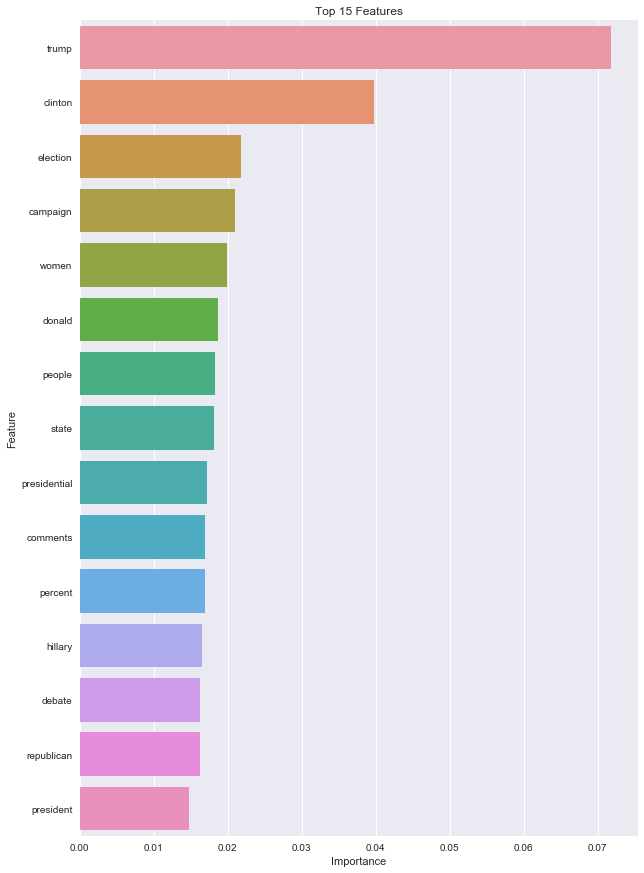

In [24]:
plt.figure(figsize=(10, 15))

ax = sns.barplot(
        x="tfidf",
        y="feature",
        data=sorted_df[0:15])

ax.set_title("Top 15 Features")
ax.set_ylabel("Feature")
ax.set_xlabel("Importance")

plt.show()

For further analysis on the data, we will use the following approaches:
- There are nearly 600 different sources in our subsample from the Corpus database. We hope to analyze trends for across these sources to account for differences between different newsources.
- We will also incorporate the genre of the source (i.e. Politics, Religion, Sports, etc.) to complete a more refined analysis. 
- Lastly, we will compare trends between sources that mention the 'election' or 'Trump' with those that do not to see which topics are more heavily associated with the election.

### 3.What is the influence of the political system in place?

For checking the demonstrations covered in media, we can try to classify newspapers as Republican or Democrat. Once we have a fairly accurate classification model, we will try to use the same analysis used to answer Question 2, to find words such as "demonstration", "violence", "protests", etc. and see how frequently (and importantly using TF-IDF) they are mentioned in the Republic and Democrat newspapers.

In [25]:
abstention_df = pd.DataFrame(columns=['Country',
                                'Past Election Cycle 1',
                                'Past Election Cycle 2',
                                'Past Election Cycle 3',
                                'Past Election Cycle 4',
                                'Past Election Cycle 5'])

In [26]:
abstention_df.loc[len(abstention_df)] = ['United States',
                                         '55.5%',
                                         '54.9%',
                                         '58.2%',
                                         '55.7%',
                                         '50.3%']

abstention_df.loc[len(abstention_df)] = ['United Kingdom',
                                         '68.7%',
                                         '66.1%',
                                         '65.1%',
                                         '61.4%',
                                         '59.4%']
abstention_df.head()

,Country,Past Election Cycle 1,Past Election Cycle 2,Past Election Cycle 3,Past Election Cycle 4,Past Election Cycle 5
0,United States,55.5%,54.9%,58.2%,55.7%,50.3%
1,United Kingdom,68.7%,66.1%,65.1%,61.4%,59.4%


Sources: 
- https://en.wikipedia.org/wiki/Voter_turnout_in_the_United_States_presidential_elections#Turnout_statistics
- http://www.ukpolitical.info/Turnout45.htm

### 4. How far in time could we have traced the roots of such events? (Wikidata, Newspapers)

To trace how far back in time these events started, we need to look at US news sources and their articles from all the way back in 2010 to 2016. By using the Fasttext method, we query (of the form A - B + C) as "immigration - Trump + policy" to get articles on immigration where Trump was not involved and that concerned policy. We can find trending words relating to each query and see which year saw such events and ideas starting to form their roots. The same can be extended to Brexit to observe how far back certain ideas or opinions were being formed.